In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import make_column_selector, ColumnTransformer
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import holidays
import datetime
import wbdata
import pycountry

/home/voltsy/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-05-31 13:48:14.564395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748670495.258714    7002 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748670495.404486    7002 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748670496.776132    7002 computation_placer.cc:17

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
train

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [3]:
train.describe()

,id,date,num_sold
count,230130.000000,230130,221259.000000
mean,115064.500000,2013-07-02 00:00:00,752.527382
min,0.000000,2010-01-01 00:00:00,5.000000
25%,57532.250000,2011-10-02 00:00:00,219.000000
50%,115064.500000,2013-07-02 00:00:00,605.000000
75%,172596.750000,2015-04-02 00:00:00,1114.000000
max,230129.000000,2016-12-31 00:00:00,5939.000000
std,66432.953062,NaN,690.165445


In [4]:
test.describe()

,id,date
count,98550.000000,98550
mean,279404.500000,2018-07-02 00:00:00
min,230130.000000,2017-01-01 00:00:00
25%,254767.250000,2017-10-01 00:00:00
50%,279404.500000,2018-07-02 00:00:00
75%,304041.750000,2019-04-02 00:00:00
max,328679.000000,2019-12-31 00:00:00
std,28449.078852,NaN


In [5]:
train.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [6]:
test.isnull().sum()

id         0
date       0
country    0
store      0
product    0
dtype: int64

In [3]:
#Feature engineering
train['month'] = train['date'].dt.to_period('M').dt.to_timestamp()
test['month'] = test['date'].dt.to_period('M').dt.to_timestamp()
train['day_of_week'] = train["date"].dt.dayofweek
train['day'] = train["date"].dt.day
train['year'] = train["date"].dt.year
train['is_weekend'] = train['day_of_week'].isin([5, 6])
train['weekofyear'] = train["date"].dt.isocalendar().week

# Function to check if a date is a holiday for that country
def is_holiday(row):
    try:
        country_code = row['country']  # make sure this matches ISO format like 'PH', 'US', etc.
        date = row['date']
        return date in holidays.country_holidays(country_code)
    except:
        return False  # if country is invalid, default to False

# Apply function row-wise
train['is_holiday'] = train.apply(is_holiday, axis=1)

In [8]:
train

,id,date,country,store,product,num_sold,month,day_of_week,day,year,is_weekend,weekofyear,is_holiday
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010-01-01,4,1,2010,False,53,True
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010-01-01,4,1,2010,False,53,True
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010-01-01,4,1,2010,False,53,True
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010-01-01,4,1,2010,False,53,True
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010-01-01,4,1,2010,False,53,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,2016-12-01,5,31,2016,True,52,False
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,2016-12-01,5,31,2016,True,52,False
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,2016-12-01,5,31,2016,True,52,False
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,2016-12-01,5,31,2016,True,52,False


In [4]:
# Economic indicators to fetch
# Define indicators
indicators = {
    'NY.GDP.MKTP.CD': 'gdp',                     # GDP (in dollars)
    'SL.UEM.TOTL.ZS': 'unemployment',            # Unemployment rate (%)
    'FP.CPI.TOTL.ZG': 'inflation',               # CPI Inflation (%)
    'FR.INR.LEND': 'interest_rate'               # Lending interest rate (%)
}

# Get country list
countries = train['country'].unique().tolist()
def get_country_code(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None  # Or handle missing countries as you like

# Example: Map the country names in your DataFrame
train['country_code'] = train['country'].apply(get_country_code)

# Now you can get the unique codes
countries = train['country_code'].dropna().unique().tolist()


# Define date range (wbdata is yearly, not monthly!)
min_year = train['month'].min().year
max_year = train['month'].max().year
start_date = datetime.datetime(min_year, 1, 1)
end_date = datetime.datetime(max_year, 12, 31)

# Fetch World Bank data (note: data is annual)
econ_frames = []
for country in countries:
    df = wbdata.get_dataframe(
        indicators,
        country=country,
        date=(start_date, end_date),  
    )
    df['country'] = country
    econ_frames.append(df)

# Combine all country data
econ_data = pd.concat(econ_frames).reset_index()

# Format and align
econ_data['date'] = pd.to_datetime(econ_data['date'], errors='coerce')
econ_data['month'] = econ_data['date'].dt.to_period('M').dt.to_timestamp()

# Merge with train and test
train = train.merge(econ_data, how='left', on=['country', 'month'])
test = test.merge(econ_data, how='left', on=['country', 'month'])

#dropping the date_x by renaming it with date
train["date"] = train["date_x"]

train.to_csv("train_data.csv", index=False)

/tmp/ipykernel_7002/1111808814.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  econ_data = pd.concat(econ_frames).reset_index()


In [10]:
train

,id,date_x,country,store,product,num_sold,month,day_of_week,day,year,is_weekend,weekofyear,is_holiday,country_code,date_y,gdp,unemployment,inflation,interest_rate,date
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010-01-01,4,1,2010,False,53,True,CAN,NaT,NaN,NaN,NaN,NaN,2010-01-01
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010-01-01,4,1,2010,False,53,True,CAN,NaT,NaN,NaN,NaN,NaN,2010-01-01
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010-01-01,4,1,2010,False,53,True,CAN,NaT,NaN,NaN,NaN,NaN,2010-01-01
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010-01-01,4,1,2010,False,53,True,CAN,NaT,NaN,NaN,NaN,NaN,2010-01-01
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010-01-01,4,1,2010,False,53,True,CAN,NaT,NaN,NaN,NaN,NaN,2010-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,2016-12-01,5,31,2016,True,52,False,SGP,NaT,NaN,NaN,NaN,NaN,2016-12-31
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,2016-12-01,5,31,2016,True,52,False,SGP,NaT,NaN,NaN,NaN,NaN,2016-12-31
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,2016-12-01,5,31,2016,True,52,False,SGP,NaT,NaN,NaN,NaN,NaN,2016-12-31
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,2016-12-01,5,31,2016,True,52,False,SGP,NaT,NaN,NaN,NaN,NaN,2016-12-31


In [11]:
train['month'] = train["date"].dt.month
train['day'] = train["date"].dt.day
train['weekday'] = train["date"].dt.weekday
train['weekofyear'] = train["date"].dt.isocalendar().week.astype(int)
train['is_weekend'] = train['weekday'].isin([5, 6]).astype(int)
train['quarter'] = train["date"].dt.quarter

for lag in [1, 2, 3, 7, 14, 28]:
    train[f'lag_{lag}'] = train.groupby(['country', 'store', 'product'])['num_sold'].shift(lag)

# --- Rolling Mean & Std Features ---
train['rolling_7'] = train.groupby(['country', 'store', 'product'])['num_sold'].shift(1).rolling(window=7).mean()
train['rolling_30'] = train['num_sold'].rolling(30).mean()
train['rolling_14'] = train.groupby(['country', 'store', 'product'])['num_sold'].shift(1).rolling(window=14).mean()
train['rolling_std_7'] = train.groupby(['country', 'store', 'product'])['num_sold'].shift(1).rolling(window=7).std()

# --- Expanding Mean ---
train['expanding_mean'] = train.groupby(['country', 'store', 'product'])['num_sold'].transform(lambda x: x.shift(1).expanding().mean())

# --- Sales Dynamics ---
train['sales_diff'] = train['lag_1'] - train['lag_2']
train['sales_growth'] = train['lag_1'] / (train['lag_2'] + 1e-5)

# --- Categorical Encoding (LabelEncoder for XGBoost) ---
label_encoders = {}
for col in ['country', 'store', 'product']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le  # keep if you want to decode later

# --- Interaction Features ---
train['country_product'] = train['country'].astype(str) + '_' + train['product'].astype(str)
train['store_product'] = train['store'].astype(str) + '_' + train['product'].astype(str)
train['country_store'] = train['country'].astype(str) + '_' + train['store'].astype(str)

for col in ['country_product', 'store_product', 'country_store']:
    train[col] = LabelEncoder().fit_transform(train[col])

#filling na values
train = train.fillna(0)

/tmp/ipykernel_1773/1172045502.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train = train.fillna(0)


In [12]:
#Data Visualization

<Axes: title={'center': 'Sales over time'}>

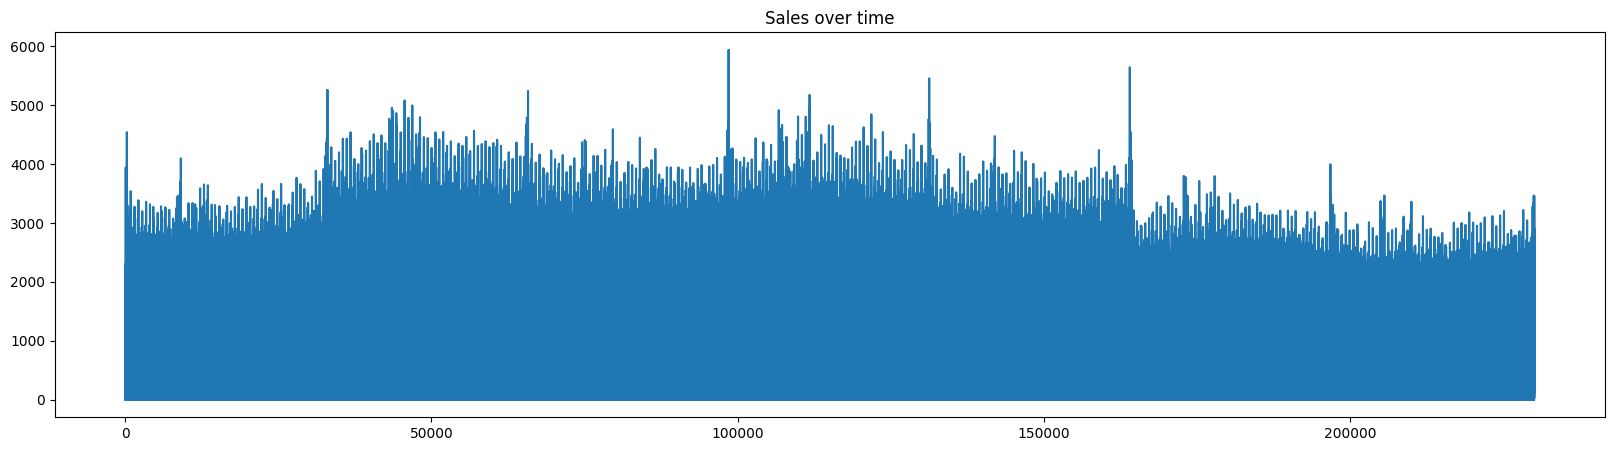

In [13]:
train["num_sold"].plot(figsize=(20, 5), title="Sales over time")
#plt.savefig("Sales Over Time.png")

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

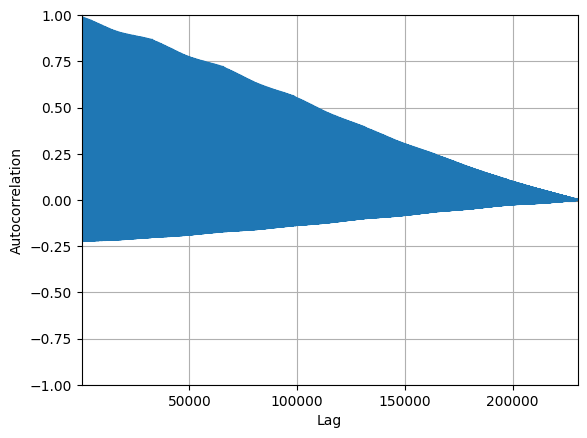

In [14]:
autocorrelation_plot(train["num_sold"])
#plt.title("Correlation between Past Values")
#plt.savefig("Evidence of Past Values affecting the future.png")

Text(0.5, 1.0, 'Sales on Holidays vs Non-Holidays')

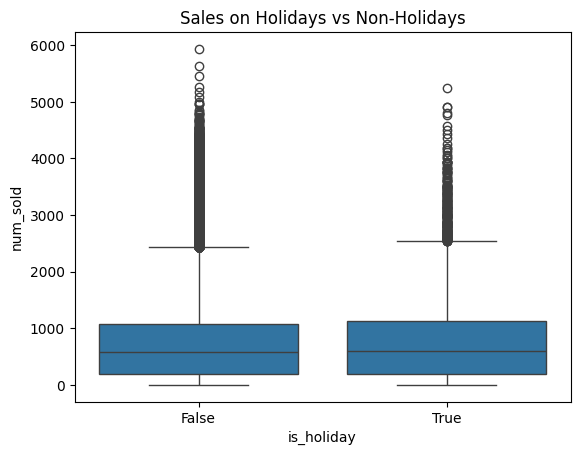

In [15]:
sns.boxplot(x=train['is_holiday'], y=train['num_sold'], data=train.reset_index())
#plt.savefig("Impact of Sales on Holidays vs Holidays")
plt.title("Sales on Holidays vs Non-Holidays")

Text(0.5, 1.0, 'Avg Monthly Sales')

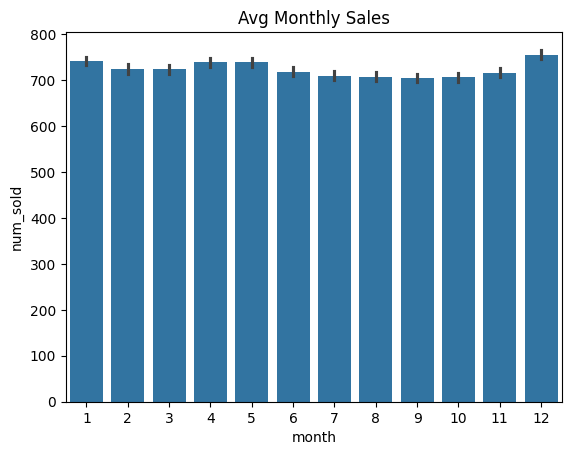

In [16]:
# Average sales by month
sns.barplot(x=train['month'], y=train['num_sold'], data=train.reset_index())
#plt.savefig("Average Monthly Sales.png")
plt.title("Avg Monthly Sales")

Text(0.5, 1.0, 'Avg Sales by Day of Week')

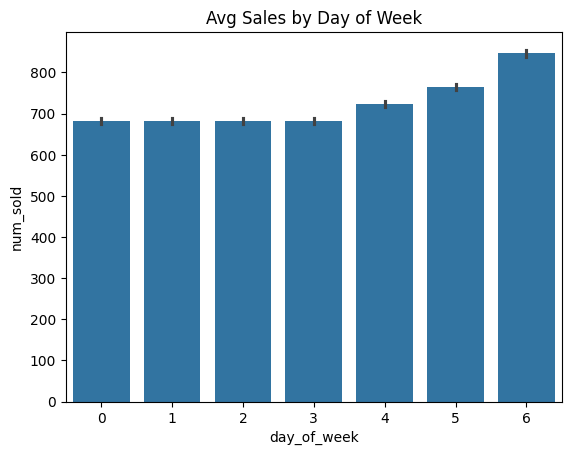

In [17]:
# Day-of-week visualization
sns.barplot(x=train['day_of_week'], y=train['num_sold'], data=train.reset_index())
#plt.savefig("Average Sales by Day of The Week.png")
plt.title("Avg Sales by Day of Week")

<Axes: >

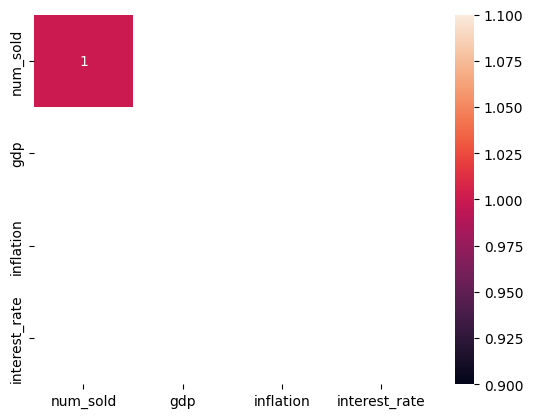

In [18]:
#Economic Relationship
sns.heatmap(train[['num_sold', 'gdp', 'inflation', 'interest_rate']].corr(), annot=True)
#plt.savefig("Economic Relationships.png")

<Axes: title={'center': 'Sales with Rolling Means'}>

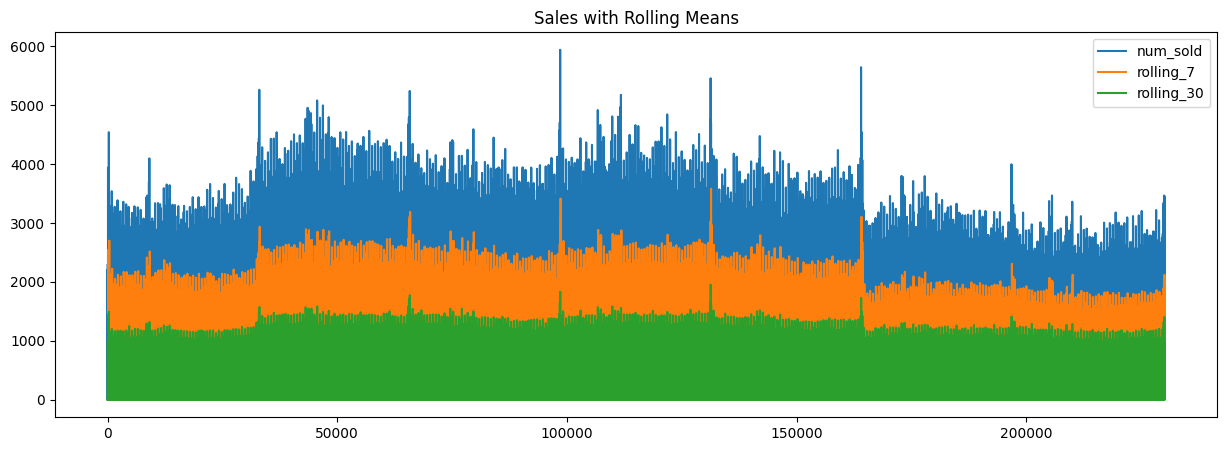

In [19]:
train[['num_sold', 'rolling_7', 'rolling_30']].plot(figsize=(15,5), title="Sales with Rolling Means")
#plt.savefig("Number of Goods Sold with Rolling Means")

In [20]:
#model building
X = train[[i for i in train.columns if i not in ["num_sold", "date_x", "country"]]]
y = train["num_sold"]


X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Selectors
num_selector = make_column_selector(dtype_include=np.number)

# Preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_selector)
])

xgb_pipeline = Pipeline([
    ('scaler', preprocessor),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Parameter grid
xgb_param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1.0]
}

# Grid search
xgb_grid = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1, verbose=1, error_score='raise')
xgb_grid.fit(X_train, Y_train)

# Results
print("Best XGB Params:", xgb_grid.best_params_)
print("Best XGB Score (CV MSE):", -xgb_grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
#Fitting 5 folds for each of 16 candidates, totalling 80 fits
#Best XGB Params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}
#Best XGB Score (CV MSE): 472319.21083796927

In [ ]:
#now were using ridge to stack models in order to have a better model prediction

In [ ]:
# Define the base models inside pipelines (with the same preprocessor)
xgb_pipeline = Pipeline([
    ('scaler', preprocessor),
    ('xgb', XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.1,
        max_depth=3,
        n_estimators=100,
        subsample=1.0,
        tree_method="gpu_hist",
        enable_categorical=True,
        random_state=42
    ))
])

ridge_pipeline = Pipeline([
    ('scaler', preprocessor),
    ('ridge', Ridge())
])

# Create stacking regressor with Ridge as the final estimator
stacking_regressor = StackingRegressor(
    estimators=[
        ('xgb', xgb_pipeline),
        ('ridge', ridge_pipeline)
    ],
    final_estimator=Ridge(),
    cv=5,
    n_jobs=-1,
    passthrough=False  # can set True to pass original features to final estimator
)

# Fit the stacking regressor on training data
stacking_regressor.fit(X_train, Y_train)